"""
# Arabic LSTM Language Model

This notebook demonstrates how to build an LSTM-based language model for Arabic text
that can predict the next token in a sequence.

## What the Steps are:
1. **Text Preprocessing**: Clean and tokenize Arabic text
2. **Vocabulary Building**: Create word-to-index mappings
3. **LSTM Architecture**: Build neural network for language modeling
4. **Training Process**: Train the model on Arabic data
5. **Text Generation**: Generate new Arabic text
6. **Next Token Prediction**: Predict most likely next words

## Requirements:
```bash
pip install torch datasets matplotlib arabic-reshaper python-bidi
```



## Step 1: Import Required Libraries


In [2]:
# Core libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Data handling
from datasets import load_dataset
import numpy as np
import pickle
import os

# Text processing
import re
from collections import Counter
from typing import Dict, List, Tuple, Optional

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The device is using: {device}")

The device is using: cuda



## Step 2: Load Arabic Dataset from HuggingFace

**First, I will load our data!**

This section loads Arabic text data from HuggingFace datasets. We provide multiple options:

### Arabic Datasets:
  **- OSCAR** - Large multilingual corpus



### Dataset Loading:


In [3]:
#!pip install -U datasets
!pip install fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requi

In [4]:
def load_arabic_data(dataset_choice, config_name=None, num_samples=10):
    """
    Load a small Arabic dataset sample from Hugging Face.

    Args:
        dataset_choice (str): Dataset name.
        config_name (str or None): Configuration (e.g., for OSCAR).
        num_samples (int): Number of samples to load.

    Returns:
        List[str]: Arabic text samples.
    """
    print(f"📥 Loading {num_samples} Arabic texts from '{dataset_choice}'...")

    try:
        # Load full train split
        dataset = load_dataset(dataset_choice, config_name, split="train", streaming=True)

        # Take only a few
        texts = []
        for sample in dataset:
          if sample.get("text", "").strip():
              texts.append(sample["text"].strip())
          if len(texts) >= num_samples:
              break

        print(f"✅ Loaded {len(texts)} samples from '{dataset_choice}'")
        return texts

    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        return None


In [5]:
# DATASET LOADING CONFIGURATION
dataset_choice = 'oscar'
config_name = "unshuffled_deduplicated_ar"
num_samples = 5000

texts = load_arabic_data(dataset_choice, config_name, num_samples)

📥 Loading 5000 Arabic texts from 'oscar'...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Loaded 5000 samples from 'oscar'


In [6]:
print(f"\n📊 Dataset Statistics:")
print(f"   Total texts loaded: {len(texts)}")
print(f"   Average text length: {np.mean([len(text.split()) for text in texts]):.1f} words")
print(f"   Shortest text: {min([len(text.split()) for text in texts])} words")
print(f"   Longest text: {max([len(text.split()) for text in texts])} words")

print(f"\n📝 Sample text preview:")
print(f"   Text 1: {texts[0][:100]}...")
if len(texts) > 1:
    print(f"   Text 2: {texts[1][:100]}...")


📊 Dataset Statistics:
   Total texts loaded: 5000
   Average text length: 436.2 words
   Shortest text: 7 words
   Longest text: 41782 words

📝 Sample text preview:
   Text 1: مرحبا بك عزيز الزائر نتمنى لك أوقاتاً سعيدة معنا وأن نزداد شرفا بخدمتك ولا تنسى التسجيل معنا لتستفيد...
   Text 2: ش سورة الفاتحة سورة البقرة سورة آل عمران سورة النساء سورةالمائدة سورة الاْنعام سورة الاْعراف سورة ال...


## Step 3: Arabic Text Tokenizer

Now that we have our data loaded, let's build the tokenizer that handles:
- **Cleaning**: Remove diacritics, normalize text
- **Tokenization**: Split text into words
- **Vocabulary**: Build word-to-index mappings
- **Encoding/Decoding**: Convert between text and numbers

In [8]:
class ArabicTokenizer:
  """Custom tokenizer for Arabic text processing"""

  def __init__(self, vocab_size):
    self.vocab_size = vocab_size
    self.word_to_idx = {}
    self.idx_to_word = {}
    self.vocab_built = False

    self.PAD_TOKEN = '<PAD>'
    self.UNK_TOKEN = '<UNK>'
    self.START_TOKEN = '<SOS>'
    self.END_TOKEN = '<EOS>'

    print(f"Tokenizer initialized with vocabulary size: {self.vocab_size}")

  def clean_arabic_text(self, text):
    """Clean and normalize Arabic text"""
    # Remove diacritics (tashkeel)
    text = re.sub(r'[\u064B-\u065F\u0670]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Remove English characters and numbers
    text = re.sub(r'[a-zA-Z0-9]', '', text)

    # Keep only Arabic characters and punctuation
    text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF\s\u060C\u061B\u061F\u0640]', '', text)

    return text.strip()


  def tokenize(self, texts):
    """Tokenize a list of Arabic texts"""
    cleaned_text = self.clean_arabic_text(texts)
    pattern = r'[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF]+'
    tokens = re.findall(pattern , cleaned_text)
    return [token for token in tokens if token.strip()]


  def build_vocab(self, texts):
    """Build the vocabulary from a list of Arabic texts"""
    print("Building vocabulary...")

    # Collect all tokens
    tokens = []
    for text in texts:
      tokens.extend(self.tokenize(text))

    # Count frequencies
    token_counts = Counter(tokens)

    # Create vocabulary
    vocab = [self.PAD_TOKEN, self.UNK_TOKEN, self.START_TOKEN, self.END_TOKEN]
    most_common = token_counts.most_common(self.vocab_size - len(vocab))
    vocab.extend([token for token, _ in most_common])

    # Create mappings
    self.word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    self.idx_to_word = {idx: word for idx, word in enumerate(vocab)}
    self.vocab_built = True

    print(f"Vocabulary built with {len(self.word_to_idx)} tokens")
    print(f"Most common words: {[token for token, _ in token_counts.most_common(10)]}")

  def encoder(self, text):
    """Convert text to indices"""
    if not self.vocab_built:
      raise ValueError("Vocabulary not built. Call build_vocab() first.")
    tokens = self.tokenize(text)
    return [self.word_to_idx.get(token, self.word_to_idx[self.UNK_TOKEN]) for token in tokens]

  def decoder(self, indices):
    """Convert indices to text"""
    tokens = [self.idx_to_word.get(idx, self.UNK_TOKEN) for idx in indices]
    return ' '.join(tokens)



In [9]:
# Test the tokenizer
print("=== Testing Arabic Tokenizer ===")
sample_text = "هذا نص تجريبي باللغة العربية الجميلة"
tokenizer = ArabicTokenizer(vocab_size=2)

print(f"Original: {sample_text}")
print(f"Cleaned: {tokenizer.clean_arabic_text(sample_text)}")
print(f"Tokens: {tokenizer.tokenize(sample_text)}")

=== Testing Arabic Tokenizer ===
Tokenizer initialized with vocabulary size: 2
Original: هذا نص تجريبي باللغة العربية الجميلة
Cleaned: هذا نص تجريبي باللغة العربية الجميلة
Tokens: ['هذا', 'نص', 'تجريبي', 'باللغة', 'العربية', 'الجميلة']


## Step 4: Dataset Class

This class prepares data for LSTM training by:
- Converting texts to sequences of indices
- Creating input-target pairs for next token prediction
- Handling padding for variable length sequences

In [10]:
class ArabicLSTMDataset(Dataset):
  """ Dataset for LSTM lnaguage modeling """

  def __init__(self, texts, tokenizer, sequence_length = 50):
    self.tokenizer = tokenizer
    self.sequence_length = sequence_length
    self.sequences = [] # Corrected variable name

    print(f"Creating sequences of length {self.sequence_length}...")

    for text in texts:
      encoded  = tokenizer.encoder(text)
      # Only process sequences long enough to create at least one input/target pair
      if len(encoded) > 1:
        # Sliding window sequences
        for i in range(len(encoded) - 1): # Corrected range
          end_idx = min(i + sequence_length, len(encoded))
          # Ensure there is at least one target token
          if end_idx - i > 0:
              input_seq = encoded[i:end_idx]
              target_seq = encoded[i+1:end_idx+1]

              # Pad if needed
              pad_id = tokenizer.word_to_idx[tokenizer.PAD_TOKEN]
              # Pad input sequence
              while len(input_seq) < sequence_length:
                  input_seq.append(pad_id)
              # Pad target sequence to match input sequence length
              while len(target_seq) < sequence_length:
                  target_seq.append(pad_id)


              self.sequences.append((input_seq, target_seq))

    print(f"Created {len(self.sequences)} training sequences") # Corrected indentation

  def __len__(self): # Added __len__ method
      return len(self.sequences)

  def __getitem__(self, idx): # Corrected indentation
      input_seq, target_seq = self.sequences[idx]
      return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)

## Step 5: LSTM Model Architecture

The LSTM model consists of:
1. **Embedding Layer**: Converts word indices to dense vectors
2. **LSTM Layers**: Process sequences and maintain memory
3. **Dropout**: Prevents overfitting
4. **Output Layer**: Predicts next token probabilities

In [11]:
class ArabicLSTM(nn.Module):
  """ LSTM model for language modeling """

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
    super(ArabicLSTM, self).__init__()

    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    #Model layers
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(hidden_dim, vocab_size)

    self.init_weights()

    # Model info
    total_params = sum(p.numel() for p in self.parameters())
    print(f"LSTM Model created:")
    print(f"  - Vocabulary size: {vocab_size}")
    print(f"  - Embedding dimension: {embedding_dim}")
    print(f"  - Hidden dimension: {hidden_dim}")
    print(f"  - Number of layers: {num_layers}")
    print(f"  - Total parameters: {total_params:,}")


  def init_weights(self):
    """Initialize weights"""
    initrange = 0.1
    self.embedding.weight.data.uniform_(-initrange, initrange)
    # Corrected from output_layer to fc
    self.fc.weight.data.uniform_(-initrange, initrange)
    self.fc.bias.data.zero_()

  def forward(self, input, hidden):
    """Forward pass"""
    embedded = self.embedding(input)
    output, hidden = self.lstm(embedded, hidden)
    output = self.dropout(output)
    # Corrected from output_layer to fc
    output = self.fc(output)
    return output, hidden

  def init_hidden(self, batch_size):
    """Initialize hidden state"""
    return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
            torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))

## Step 6: Prepare Training Data

Build vocabulary and create datasets for training and validation using the loaded texts.

In [13]:
# Initialize tokenizer and build vocabulary from our loaded texts
tokenizer = ArabicTokenizer(vocab_size=2000)
tokenizer.build_vocab(texts)

# Split data
train_size = int(0.8 * len(texts))
train_texts = texts[:train_size]
val_texts = texts[train_size:]

print(f"Training texts: {len(train_texts)}")
print(f"Validation texts: {len(val_texts)}")

# Create datasets
sequence_length = 25
train_dataset = ArabicLSTMDataset(train_texts, tokenizer, sequence_length)
val_dataset = ArabicLSTMDataset(val_texts, tokenizer, sequence_length)

# Show vocabulary statistics
vocab_size = len(tokenizer.word_to_idx)
print(f"\nVocabulary statistics:")
print(f"Total vocabulary size: {vocab_size}")
print(f"Training sequences: {len(train_dataset)}")
print(f"Validation sequences: {len(val_dataset)}")

Tokenizer initialized with vocabulary size: 2000
Building vocabulary...
Vocabulary built with 2000 tokens
Most common words: ['في', 'من', 'على', 'و', 'أن', '،', 'إلى', 'عن', 'التي', 'منتدى']
Training texts: 4000
Validation texts: 1000
Creating sequences of length 25...
Created 1568932 training sequences
Creating sequences of length 25...
Created 458781 training sequences

Vocabulary statistics:
Total vocabulary size: 2000
Training sequences: 1568932
Validation sequences: 458781


## Step 7: Create and Configure Model

Initialize the LSTM model with our vocabulary.

In [14]:
# Model hyperparameters
model_config = {
    'vocab_size': vocab_size,
    'embedding_dim': 256,
    'hidden_dim': 512,
    'num_layers': 5,
    'dropout': 0.3
}

# Create model
model = ArabicLSTM(**model_config).to(device)

print(f"Model moved to device: {device}")

LSTM Model created:
  - Vocabulary size: 2000
  - Embedding dimension: 256
  - Hidden dimension: 512
  - Number of layers: 5
  - Total parameters: 11,519,952
Model moved to device: cuda


## Step 8: Training Setup

Configure training parameters and data loaders.

In [15]:
# Training parameters
EPOCHS = 1
BATCH_SIZE = 16
LEARNING_RATE = 0.001

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word_to_idx[tokenizer.PAD_TOKEN])

print(f"Training configuration:")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Training batches: {len(train_loader)}")
print(f"  - Validation batches: {len(val_loader)}")

Training configuration:
  - Epochs: 1
  - Batch size: 16
  - Learning rate: 0.001
  - Training batches: 98059
  - Validation batches: 28674


## Step 9: Training Loop

Train the model and track performance.

In [16]:
# Training history
train_losses = []
val_losses = []

print("Starting training...")
print("=" * 50)

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    train_batches = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        hidden = model.init_hidden(inputs.size(0))
        outputs, hidden = model(inputs, hidden)

        # Calculate loss
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()
        train_batches += 1

        # Print progress
        if batch_idx % 20 == 0:
            print(f'Epoch {epoch+1}/{EPOCHS}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    # Validation phase
    model.eval()
    val_loss = 0
    val_batches = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            hidden = model.init_hidden(inputs.size(0))
            outputs, hidden = model(inputs, hidden)

            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            val_loss += loss.item()
            val_batches += 1

    # Calculate averages
    avg_train_loss = train_loss / train_batches
    avg_val_loss = val_loss / val_batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} Summary:')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Val Loss: {avg_val_loss:.4f}')
    print("-" * 30)

print("Training completed!")

Starting training...
Epoch 1/1, Batch 0/98059, Loss: 7.5982
Epoch 1/1, Batch 20/98059, Loss: 3.7672
Epoch 1/1, Batch 40/98059, Loss: 3.6582
Epoch 1/1, Batch 60/98059, Loss: 4.0866
Epoch 1/1, Batch 80/98059, Loss: 3.8294
Epoch 1/1, Batch 100/98059, Loss: 3.8062
Epoch 1/1, Batch 120/98059, Loss: 4.5751
Epoch 1/1, Batch 140/98059, Loss: 3.7768
Epoch 1/1, Batch 160/98059, Loss: 4.1460
Epoch 1/1, Batch 180/98059, Loss: 4.1136
Epoch 1/1, Batch 200/98059, Loss: 4.0580
Epoch 1/1, Batch 220/98059, Loss: 3.8131
Epoch 1/1, Batch 240/98059, Loss: 4.0850
Epoch 1/1, Batch 260/98059, Loss: 3.9824
Epoch 1/1, Batch 280/98059, Loss: 3.8871
Epoch 1/1, Batch 300/98059, Loss: 4.1706
Epoch 1/1, Batch 320/98059, Loss: 4.0486
Epoch 1/1, Batch 340/98059, Loss: 4.0817
Epoch 1/1, Batch 360/98059, Loss: 3.8054
Epoch 1/1, Batch 380/98059, Loss: 4.2200
Epoch 1/1, Batch 400/98059, Loss: 3.6170
Epoch 1/1, Batch 420/98059, Loss: 3.6085
Epoch 1/1, Batch 440/98059, Loss: 4.0074
Epoch 1/1, Batch 460/98059, Loss: 3.9658
E

## Step 10: Visualize Training Progress

Plot training and validation loss over time.


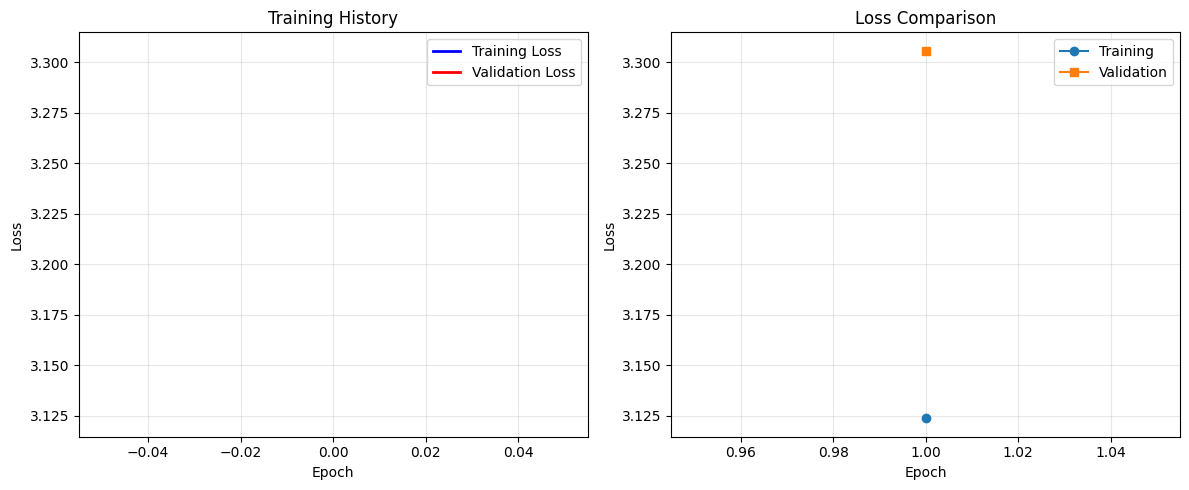

Final Training Loss: 3.1238
Final Validation Loss: 3.3057


In [17]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses)+1), train_losses, 'o-', label='Training')
plt.plot(range(1, len(val_losses)+1), val_losses, 's-', label='Validation')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

## Step 11: Next Token Prediction

Test the model's ability to predict the next token given some input text.

In [18]:
def predict_next_token(model, tokenizer, text: str, top_k: int = 5):
    """Predict next token for given text"""
    model.eval()

    # Encode input
    encoded = tokenizer.encoder(text)
    if not encoded:
        return []

    input_seq = torch.tensor([encoded], dtype=torch.long).to(device)

    with torch.no_grad():
        hidden = model.init_hidden(1)
        outputs, hidden = model(input_seq, hidden)

        # Get predictions for last position
        last_predictions = outputs[0, -1, :]
        probabilities = torch.softmax(last_predictions, dim=0)

        # Get top-k predictions
        top_k_probs, top_k_indices = torch.topk(probabilities, top_k)

        results = []
        for i in range(top_k):
            token_idx = top_k_indices[i].item()
            prob = top_k_probs[i].item()
            token = tokenizer.idx_to_word[token_idx]

            results.append({
                'token': token,
                'probability': prob,
                'rank': i + 1
            })

    return results

# Test next token prediction
test_texts = [
    "اللغة العربية",
    "التعلم الآلي",
    "الذكاء الاصطناعي",
    "التكنولوجيا الحديثة"
]

print("=== Next Token Prediction Results ===")
print()

for test_text in test_texts:
    print(f"Input text: '{test_text}'")
    predictions = predict_next_token(model, tokenizer, test_text, top_k=5)

    print("Top 5 predictions:")
    for pred in predictions:
        print(f"  {pred['rank']}. '{pred['token']}' (probability: {pred['probability']:.3f})")
    print("-" * 50)

=== Next Token Prediction Results ===

Input text: 'اللغة العربية'
Top 5 predictions:
  1. '<UNK>' (probability: 0.270)
  2. 'اللغة' (probability: 0.173)
  3. 'للسنة' (probability: 0.158)
  4. 'الرياضيات' (probability: 0.076)
  5. 'و' (probability: 0.061)
--------------------------------------------------
Input text: 'التعلم الآلي'
Top 5 predictions:
  1. '<UNK>' (probability: 0.560)
  2. 'في' (probability: 0.031)
  3. 'من' (probability: 0.023)
  4. 'على' (probability: 0.016)
  5. 'و' (probability: 0.009)
--------------------------------------------------
Input text: 'الذكاء الاصطناعي'
Top 5 predictions:
  1. '<UNK>' (probability: 0.560)
  2. 'في' (probability: 0.031)
  3. 'من' (probability: 0.023)
  4. 'على' (probability: 0.016)
  5. 'و' (probability: 0.009)
--------------------------------------------------
Input text: 'التكنولوجيا الحديثة'
Top 5 predictions:
  1. '<UNK>' (probability: 0.499)
  2. 'منتدى' (probability: 0.069)
  3. 'قسم' (probability: 0.049)
  4. 'و' (probability: 0.0

## Step 12: Text Generation

Generate new Arabic text starting from a seed phrase.

In [19]:
def generate_text(model, tokenizer, seed_text: str, max_length: int = 20, temperature: float = 0.8):
    """Generate text starting from seed"""
    model.eval()

    # Encode seed
    encoded = tokenizer.encoder(seed_text)
    if not encoded:
        encoded = [tokenizer.word_to_idx[tokenizer.START_TOKEN]]

    generated = encoded.copy()

    with torch.no_grad():
        hidden = model.init_hidden(1)

        for _ in range(max_length):
            # Use last sequence_length tokens
            input_seq = torch.tensor([generated[-sequence_length:]], dtype=torch.long).to(device)

            # Get prediction
            outputs, hidden = model(input_seq, hidden)
            last_output = outputs[0, -1, :] / temperature

            # Sample next token
            probabilities = torch.softmax(last_output, dim=0)
            next_token = torch.multinomial(probabilities, 1).item()

            # Stop conditions
            if next_token == tokenizer.word_to_idx.get(tokenizer.END_TOKEN, -1):
                break
            if next_token == tokenizer.word_to_idx[tokenizer.PAD_TOKEN]:
                continue

            generated.append(next_token)

    return tokenizer.decoder(generated)

# Test text generation
seed_texts = [
    "اللغة العربية",
    "التعلم الآلي",
    "التكنولوجيا",
    "المستقبل"
]

print("=== Text Generation Results ===")
print()

for seed in seed_texts:
    generated = generate_text(model, tokenizer, seed, max_length=15, temperature=0.8)
    print(f"Seed: '{seed}'")
    print(f"Generated: '{generated}'")
    print("-" * 60)

=== Text Generation Results ===

Seed: 'اللغة العربية'
Generated: 'اللغة العربية منتدى اللغة الانجليزية اللغة <UNK> منتدى <UNK> منتدى <UNK> منتدى <UNK> <UNK> منتدى <UNK> <UNK>'
------------------------------------------------------------
Seed: 'التعلم الآلي'
Generated: '<UNK> <UNK> في <UNK> <UNK> <UNK> <UNK> <UNK> من <UNK> <UNK> <UNK> <UNK> <UNK> جدا تقدم <UNK>'
------------------------------------------------------------
Seed: 'التكنولوجيا'
Generated: 'التكنولوجيا برامج <UNK> <UNK> برامج <UNK> <UNK> <UNK> برامج <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>'
------------------------------------------------------------
Seed: 'المستقبل'
Generated: 'المستقبل <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>'
------------------------------------------------------------


## Step 13: Model Evaluation and Analysis

Analyze the model's performance and vocabulary usage.

In [20]:
def analyze_vocabulary(tokenizer):
    """Analyze vocabulary statistics"""
    vocab_size = len(tokenizer.word_to_idx)

    print(f"Vocabulary Analysis:")
    print(f"  Total vocabulary size: {vocab_size}")
    print(f"  Special tokens: {[tokenizer.PAD_TOKEN, tokenizer.UNK_TOKEN, tokenizer.START_TOKEN, tokenizer.END_TOKEN]}")

    # Show some random vocabulary words
    import random
    vocab_words = list(tokenizer.word_to_idx.keys())
    random_words = random.sample([w for w in vocab_words if not w.startswith('<')], min(20, len(vocab_words)))
    print(f"  Sample vocabulary words: {random_words[:10]}")

analyze_vocabulary(tokenizer)

# Model performance summary
print(f"\nModel Performance Summary:")
print(f"  Final training loss: {train_losses[-1]:.4f}")
print(f"  Final validation loss: {val_losses[-1]:.4f}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Model size: ~{sum(p.numel() for p in model.parameters()) * 4 / 1024 / 1024:.1f} MB")

Vocabulary Analysis:
  Total vocabulary size: 2000
  Special tokens: ['<PAD>', '<UNK>', '<SOS>', '<EOS>']
  Sample vocabulary words: ['فهي', 'نتيجة', 'مخالف', 'وهو', 'حوالي', 'شعر', 'كفار', 'مجانية', 'ولاية', 'لحقوق']

Model Performance Summary:
  Final training loss: 3.1238
  Final validation loss: 3.3057
  Total parameters: 11,519,952
  Model size: ~43.9 MB


## Step 14: Save and Load Model

Save the trained model for future use.

In [21]:
def save_model(model, tokenizer, filepath):
    """Save model and tokenizer"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': model_config,
        'vocab_size': len(tokenizer.word_to_idx)
    }, filepath)

    # Save tokenizer
    tokenizer_path = filepath.replace('.pth', '_tokenizer.pkl')
    with open(tokenizer_path, 'wb') as f:
        pickle.dump({
            'word_to_idx': tokenizer.word_to_idx,
            'idx_to_word': tokenizer.idx_to_word,
            'vocab_size': tokenizer.vocab_size,
            'vocab_built': tokenizer.vocab_built
        }, f)

    print(f"Model saved to: {filepath}")
    print(f"Tokenizer saved to: {tokenizer_path}")

def load_model(filepath, device):
    """Load model and tokenizer"""
    # Load model
    checkpoint = torch.load(filepath, map_location=device)

    # Recreate model
    loaded_model = ArabicLSTM(**checkpoint['model_config']).to(device)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])

    # Load tokenizer
    tokenizer_path = filepath.replace('.pth', '_tokenizer.pkl')
    with open(tokenizer_path, 'rb') as f:
        tokenizer_data = pickle.load(f)

    loaded_tokenizer = ArabicTokenizer()
    loaded_tokenizer.word_to_idx = tokenizer_data['word_to_idx']
    loaded_tokenizer.idx_to_word = tokenizer_data['idx_to_word']
    loaded_tokenizer.vocab_size = tokenizer_data['vocab_size']
    loaded_tokenizer.vocab_built = tokenizer_data['vocab_built']

    return loaded_model, loaded_tokenizer

In [22]:
save_model(model, tokenizer, 'arabic_lstm_model.pth')

Model saved to: arabic_lstm_model.pth
Tokenizer saved to: arabic_lstm_model_tokenizer.pkl


## Step 15: Push the Model to Hugging face

Push the model to hugging face space.

In [30]:
!pip install --upgrade huggingface_hub

In [42]:
# Install the required libraries
!pip install -q huggingface_hub

from huggingface_hub import HfApi, notebook_login
import os

# Authenticate with Hugging Face
notebook_login()

In [47]:
repo_id = "Yousif22/arabic-lstm-demo"
print(f"Target repository: {repo_id}")

# Define the files to push
local_files = ['arabic_lstm_model.pth', 'arabic_lstm_model_tokenizer.pkl']
print(f"Files to push: {local_files}")

# Define the target directory in the repository
target_repo_dir = "models"
print(f"Target directory in repository: ./{target_repo_dir}")

# Push the files to the repository
# The create_pr=True option creates a pull request instead of pushing directly
try:
    api = HfApi()
    for file_path in local_files:
        # Construct the path within the repository
        path_in_repo = os.path.join(target_repo_dir, os.path.basename(file_path))
        api.upload_file(
            path_or_fileobj=file_path,
            path_in_repo=path_in_repo,
            repo_id=repo_id,
            repo_type="space",
            commit_message=f"Add {os.path.basename(file_path)} to {target_repo_dir}",
            create_pr=False,
        )
        print(f"Successfully pushed {os.path.basename(file_path)} to Hugging Face Space '{repo_id}/{path_in_repo}'")

except Exception as e:
    print(f"Error pushing to Hugging Face: {e}")
    print("Please ensure the repository exists and you have write access.")
    print("Also, verify your authentication token.")

Target repository: Yousif22/arabic-lstm-demo
Files to push: ['arabic_lstm_model.pth', 'arabic_lstm_model_tokenizer.pkl']
Target directory in repository: ./models
Successfully pushed arabic_lstm_model.pth to Hugging Face Space 'Yousif22/arabic-lstm-demo/models/arabic_lstm_model.pth'
Successfully pushed arabic_lstm_model_tokenizer.pkl to Hugging Face Space 'Yousif22/arabic-lstm-demo/models/arabic_lstm_model_tokenizer.pkl'


## Step 16: Interactive Testing

Create functions for easy testing of the trained model.

In [ ]:
def interactive_prediction(model, tokenizer):
    """Interactive function for testing predictions"""
    print("=== Interactive Next Token Prediction ===")
    print("Enter Arabic text to get next token predictions (type 'quit' to exit):")

    while True:
        user_input = input("\nEnter Arabic text: ").strip()

        if user_input.lower() == 'quit':
            break

        if not user_input:
            continue

        try:
            predictions = predict_next_token(model, tokenizer, user_input, top_k=3)
            print(f"\nNext token predictions for '{user_input}':")
            for pred in predictions:
                print(f"  {pred['rank']}. '{pred['token']}' ({pred['probability']:.3f})")
        except Exception as e:
            print(f"Error: {e}")

def interactive_generation(model, tokenizer):
    """Interactive function for text generation"""
    print("=== Interactive Text Generation ===")
    print("Enter seed text to generate Arabic text (type 'quit' to exit):")

    while True:
        user_input = input("\nEnter seed text: ").strip()

        if user_input.lower() == 'quit':
            break

        if not user_input:
            continue

        try:
            generated = generate_text(model, tokenizer, user_input, max_length=10)
            print(f"\nGenerated text: '{generated}'")
        except Exception as e:
            print(f"Error: {e}")

# Example usage
interactive_prediction(model, tokenizer)
interactive_generation(model, tokenizer)

print("Notebook completed successfully!")
print("\nTo test the model interactively, uncomment and run:")
print("interactive_prediction(model, tokenizer)")
print("interactive_generation(model, tokenizer)")

## Summary

This notebook demonstrated how to build an LSTM language model for Arabic text that can:

1. **Process Arabic Text**: Clean, tokenize, and encode Arabic text properly
2. **Build Vocabulary**: Create efficient word-to-index mappings
3. **Train LSTM Model**: Use PyTorch to train a neural language model
4. **Predict Next Tokens**: Given input text, predict most likely next words
5. **Generate Text**: Create new Arabic text starting from seed phrases

### Key Components:
- **ArabicTokenizer**: Handles Arabic text preprocessing and vocabulary
- **ArabicLSTMDataset**: Prepares training sequences for LSTM
- **ArabicLSTM**: Neural network architecture for language modeling
- **Training Loop**: Optimizes model parameters using gradient descent
- **Evaluation Functions**: Test model performance on various tasks

### Next Steps:
- Train on larger Arabic datasets for better performance
- Experiment with different model architectures (GRU, Transformer)
- Fine-tune hyperparameters for specific use cases